In [1]:
import os

path = os.path.join(os.getenv('HOME'),'aiffel/ocr')
os.chdir(path)

print(path)

/aiffel/aiffel/ocr


In [2]:
# 해당 디렉토리에 있는 모든 파일들의 리스트를 가져옵니다.
file_list = os.listdir(path)

# 파일 리스트를 출력합니다.
print(file_list)


['model_checkpoint_10.hdf5', 'data', 'model_checkpoint.hdf5', 'model_checkpoint_5.hdf5', 'model_checkpoint_20.hdf5']


In [3]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [4]:
import re
import six
import math
import lmdb
import os
import numpy as np
import tensorflow as tf

from PIL import Image

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model

BATCH_SIZE = 128
HOME_DIR = os.getenv('HOME')+'/aiffel/ocr'

TRAIN_DATA_PATH = HOME_DIR+'/data/MJ/MJ_train'
VALID_DATA_PATH = HOME_DIR+'/data/MJ/MJ_valid'
TEST_DATA_PATH = HOME_DIR+'/data/MJ/MJ_test'

print(TRAIN_DATA_PATH)

/aiffel/aiffel/ocr/data/MJ/MJ_train


original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


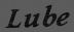

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


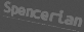

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


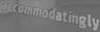

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


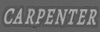

In [5]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH, 
                max_readers=32, 
                readonly=True, 
                lock=False, 
                readahead=False, 
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에 
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))
        
        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)        
        print('target_img_size:{}'.format(target_img_size))        
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요       
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [6]:
class MJDatasetSequence(Sequence):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(self, 
                 dataset_path,
                 label_converter,
                 batch_size=1,
                 img_size=(100,32),
                 max_text_len=22,
                 is_train=False,
                 character='') :
        
        self.label_converter = label_converter
        self.batch_size = batch_size
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character
        self.is_train = is_train
        self.divide_length = 100

        self.env = lmdb.open(dataset_path, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get('num-samples'.encode()))
            self.index_list = [index + 1 for index in range(self.num_samples)]
        

    def __len__(self):
        return math.ceil(self.num_samples/self.batch_size/self.divide_length)
    
    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def _get_img_label(self, index):
        with self.env.begin(write=False) as txn:
            label_key = 'label-%09d'.encode() % index
            label = txn.get(label_key).decode('utf-8')
            img_key = 'image-%09d'.encode() % index
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)
            try:
                img = Image.open(buf).convert('RGB')

            except IOError:
                img = Image.new('RGB', self.img_size)
                label = '-'
            width, height = img.size
            
            target_width = min(int(width*self.img_size[1]/height), self.img_size[0])
            target_img_size = (target_width, self.img_size[1])
            img = np.array(img.resize(target_img_size)).transpose(1,0,2)
            # label을 약간 더 다듬습니다
            label = label.upper()
            out_of_char = f'[^{self.character}]'
            label = re.sub(out_of_char, '', label)
            label = label[:self.max_text_len]

        return (img, label)
    
    # __getitem__은 약속되어있는 메서드입니다
    # 이 부분을 작성하면 slice할 수 있습니다
    # 자세히 알고 싶다면 아래 문서를 참고하세요
    # https://docs.python.org/3/reference/datamodel.html#object.__getitem__
    # 
    # 1. idx에 해당하는 index_list만큼 데이터를 불러
    # 2. image와 label을 불러오고 
    # 3. 사용하기 좋은 inputs과 outputs형태로 반환합니다
    def __getitem__(self, idx):
        # 1.
        batch_indicies = self.index_list[
            idx*self.batch_size:
            (idx+1)*self.batch_size
        ]
        input_images = np.zeros([self.batch_size, *self.img_size, 3])
        labels = np.zeros([self.batch_size, self.max_text_len], dtype='int64')

        input_length = np.ones([self.batch_size], dtype='int64') * self.max_text_len
        label_length = np.ones([self.batch_size], dtype='int64')

        # 2.
        for i, index in enumerate(batch_indicies):
            img, label = self._get_img_label(index)
            encoded_label = self.label_converter.encode(label)
            # 인코딩 과정에서 '-'이 추가되면 max_text_len보다 길어질 수 있어요
            if len(encoded_label) > self.max_text_len:
                continue
            width = img.shape[0]
            input_images[i,:width,:,:] = img
            labels[i,0:len(encoded_label)] = encoded_label
            label_length[i] = len(encoded_label)
        
        # 3.
        inputs = {
            'input_image': input_images,
            'label': labels,
            'input_length': input_length,
            'label_length': label_length,
        }
        outputs = {'ctc': np.zeros([self.batch_size, 1])}

        return inputs, outputs

print("슝~")

슝~


In [7]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label
print("슝~")

슝~


In [8]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


In [9]:
def ctc_lambda_func(args): # CTC loss를 계산하기 위한 Lambda 함수
    labels, y_pred, label_length, input_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
print("슝~")

슝~


In [10]:
def build_crnn_model(input_shape=(100,32,3), characters=TARGET_CHARACTERS):
    num_chars = len(characters)+2
    image_input = layers.Input(shape=input_shape, dtype='float32', name='input_image')
    
    # Build CRNN model
    conv = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(image_input)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)
    conv = layers.BatchNormalization()(conv)
    conv = layers.MaxPooling2D(pool_size=(1, 2))(conv)     
    feature = layers.Conv2D(512, (2, 2), activation='relu', kernel_initializer='he_normal')(conv)
    sequnce = layers.Reshape(target_shape=(24, 512))(feature)
    sequnce = layers.Dense(64, activation='relu')(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    sequnce = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(sequnce)
    y_pred = layers.Dense(num_chars, activation='softmax', name='output')(sequnce)

    labels = layers.Input(shape=[22], dtype='int64', name='label')
    input_length = layers.Input(shape=[1], dtype='int64', name='input_length')
    label_length = layers.Input(shape=[1], dtype='int64', name='label_length')
    loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name="ctc")(
        [labels, y_pred, label_length, input_length]
    )
    model_input = [image_input, labels, input_length, label_length]
    model = Model(
        inputs=model_input,
        outputs=loss_out
    )
    return model
print("슝~")

슝~


In [11]:
from tensorflow.keras import backend as K

# 데이터셋과 모델을 준비합니다
train_set = MJDatasetSequence(TRAIN_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS, is_train=True)
val_set = MJDatasetSequence(VALID_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()

# 모델을 컴파일 합니다
optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.001, clipnorm=5)

# 모델 컴파일
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)



In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

# 체크포인트 파일을 저장할 경로 설정
checkpoint_path = HOME_DIR + '/model_checkpoint_{epoch}.hdf5'
total_epochs = 20

# 한 에포크 당 배치의 총 개수를 계산
batches_per_epoch = len(train_set)

# ModelCheckpoint 콜백 설정
# 5번째, 10번째, 마지막 epoch에서 모델 저장
ckp_5 = ModelCheckpoint(
    checkpoint_path.format(epoch=5),
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=True,
    save_freq=5 * batches_per_epoch  # 5번째 에포크마다 저장
)

ckp_10 = ModelCheckpoint(
    checkpoint_path.format(epoch=10),
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=True,
    save_freq=10 * batches_per_epoch  # 10번째 에포크마다 저장
)

ckp_last = ModelCheckpoint(
    checkpoint_path.format(epoch=total_epochs),
    monitor='val_loss',
    verbose=1,
    save_best_only=False,
    save_weights_only=True,
    save_freq=total_epochs * batches_per_epoch  # 마지막 에포크에서 저장
)

# EarlyStopping 콜백 설정
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1
)

# 모델 학습
history = model.fit(
    train_set,
    steps_per_epoch=batches_per_epoch,
    epochs=total_epochs,
    validation_data=val_set,
    validation_steps=len(val_set),
    callbacks=[ckp_5, ckp_10, ckp_last, earlystop]
)

Epoch 1/20
565/565 [==============================] - 138s 151ms/step - loss: 33.5758 - val_loss: 27.3419
Epoch 2/20
565/565 [==============================] - 80s 142ms/step - loss: 26.7740 - val_loss: 26.6386
Epoch 3/20
565/565 [==============================] - 80s 142ms/step - loss: 26.3485 - val_loss: 26.3721
Epoch 4/20
565/565 [==============================] - 80s 141ms/step - loss: 26.1410 - val_loss: 26.2038
Epoch 5/20
565/565 [==============================] - ETA: 0s - loss: 26.0015
Epoch 00005: saving model to /aiffel/aiffel/ocr/model_checkpoint_5.hdf5
565/565 [==============================] - 80s 142ms/step - loss: 26.0015 - val_loss: 26.1016
Epoch 6/20
565/565 [==============================] - 80s 141ms/step - loss: 25.8937 - val_loss: 25.9950
Epoch 7/20
565/565 [==============================] - 80s 142ms/step - loss: 25.8035 - val_loss: 25.9111
Epoch 8/20
565/565 [==============================] - 80s 141ms/step - loss: 25.7239 - val_loss: 25.8308
Epoch 9/20
565/565 [

미션 2 : 학습 단계별 평가

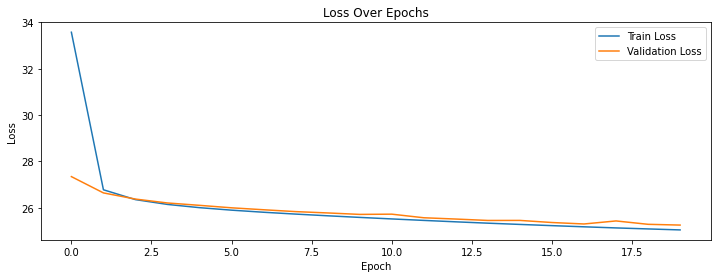

In [13]:
import matplotlib.pyplot as plt

# 학습 손실과 검증 손실 그리기
plt.figure(figsize=(12, 4))

# 손실 그래프
plt.subplot(1, 1, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


accuracy는 이번 노드에서 의미가 없어 사용하지 않았다. 

①손실 감소: 훈련 손실과 검증 손실 모두 초기 에포크에서 급격히 감소하고 있습니다. 이는 모델이 훈련 데이터에서 패턴을 학습하고 있음을 나타냅니다.

②수렴: 초기 감소 이후, 손실 값이 점차 평탄화되면서 더 이상 큰 변화가 없는 것처럼 보입니다. 이는 모델이 최적의 가중치에 접근하고 있음을 나타낼 수 있습니다.

③과적합 없음: 훈련 손실과 검증 손실이 함께 감소하고 있으며, 두 손실 값 사이에 큰 차이가 보이지 않습니다. 이는 과적합(overfitting)이 일어나지 않았음을 의미합니다. 과적합이 일어났다면, 훈련 손실은 계속 감소하지만 검증 손실은 증가하는 경향을 보일 것입니다.

④훈련과 검증의 손실 차이: 그래프에서 보이는 것처럼, 훈련 손실과 검증 손실 사이에 작은 차이가 있지만 이는 모델이 일반화를 잘 하고 있다는 신호일 수 있습니다.

In [14]:
# 테스트 데이터셋을 준비합니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)

def load_model_and_evaluate(model_path, test_set):
    # 모델 가중치 로드
    model.load_weights(model_path)

    # 모델 평가, 손실만 반환
    loss = model.evaluate(test_set, steps=len(test_set))
    return loss

# 각 체크포인트의 모델 로드 및 평가
epochs = [5, 10, total_epochs]  # 체크포인트 epoch 번호
checkpoint_paths = [HOME_DIR + f'/model_checkpoint_{epoch}.hdf5' for epoch in epochs]
results = {}

for epoch, model_path in zip(epochs, checkpoint_paths):
    loss = load_model_and_evaluate(model_path, test_set)
    results[epoch] = {'loss': loss}

# 결과 출력
for epoch in epochs:
    print(f"Epoch {epoch}: Loss = {results[epoch]['loss']}")




70/70 [==============================] - 6s 78ms/step - loss: 25.0345
Epoch 5: Loss = 25.034536361694336
Epoch 10: Loss = 25.034536361694336
Epoch 20: Loss = 25.034536361694336


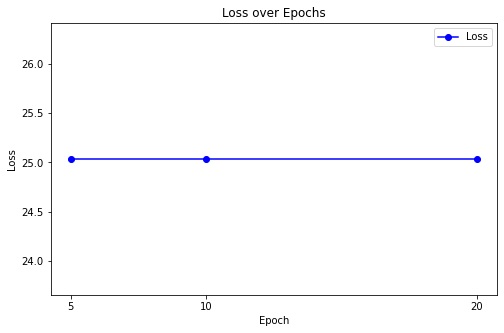

In [15]:
import matplotlib.pyplot as plt

# 체크포인트 별 손실 값
loss_values = [results[epoch]['loss'] for epoch in epochs]

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b', label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.show()


In [16]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = HOME_DIR + '/data/model_checkpoint.hdf5'

# 데이터셋과 모델을 불러옵니다
test_set = MJDatasetSequence(TEST_DATA_PATH, label_converter, batch_size=BATCH_SIZE, character=TARGET_CHARACTERS)
model = build_crnn_model()
model.load_weights(checkpoint_path)

# crnn 모델은 입력이 복잡한 구조이므로 그대로 사용할 수가 없습니다
# 그래서 crnn 모델의 입력중 'input_image' 부분만 사용한 모델을 새로 만들겁니다
# inference 전용 모델이에요 
input_data = model.get_layer('input_image').output
y_pred = model.get_layer('output').output
model_pred = Model(inputs=input_data, outputs=y_pred)

Result: 	 SLINKING9999999999999999


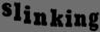

Result: 	 ALEPPO99999999999999999


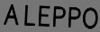

Result: 	 FWANDA999999999999999999


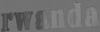

Result: 	 NATHANS99999999999999999


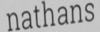

Result: 	 HALLE999999999999999999


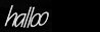

Result: 	 HURLS9999999999999999999


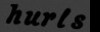

Result: 	 DOWNSIZE9999999999999999


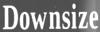

Result: 	 ROBOTIC99999999999999999


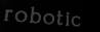

Result: 	 SLOPPY99999999999999999


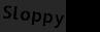

Result: 	 SHERMITE9999999999999999


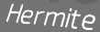

In [17]:
from IPython.display import display

# 모델이 inference한 결과를 글자로 바꿔주는 역할을 합니다
# 코드 하나하나를 이해하기는 조금 어려울 수 있습니다
def decode_predict_ctc(out, chars = TARGET_CHARACTERS):
    results = []
    indexes = K.get_value(
        K.ctc_decode(
            out, input_length=np.ones(out.shape[0]) * out.shape[1],
            greedy=False , beam_width=5, top_paths=1
        )[0][0]
    )[0]
    text = ""
    for index in indexes:
        text += chars[index]
    results.append(text)
    return results

# 모델과 데이터셋이 주어지면 inference를 수행합니다
# index개 만큼의 데이터를 읽어 모델로 inference를 수행하고
# 결과를 디코딩해 출력해줍니다
def check_inference(model, dataset, index = 5):
    for i in range(index):
        inputs, outputs = dataset[i]
        img = dataset[i][0]['input_image'][0:1,:,:,:]
        output = model.predict(img)
        result = decode_predict_ctc(output, chars="-"+TARGET_CHARACTERS)[0].replace('-','')
        print("Result: \t", result)
        display(Image.fromarray(img[0].transpose(1,0,2).astype(np.uint8)))

check_inference(model_pred, test_set, index=10)

In [18]:
#그림에 Aspect Ratio, Vertical offset을 직접 그려보기

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def add_aspect_ratio_and_vertical_offset(img, original_height, target_height):
    # Aspect Ratio 계산
    aspect_ratio = img.shape[1] / img.shape[0]

    # Vertical Offset 계산
    vertical_offset = (target_height - img.shape[0]) / 2

    # 이미지에 Aspect Ratio와 Vertical Offset 표시
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    ax.text(0.5, -0.1, f"Aspect Ratio: {aspect_ratio:.2f}", color='red', transform=ax.transAxes, ha='center')
    ax.text(0.5, -0.15, f"Vertical Offset: {vertical_offset:.2f}", color='blue', transform=ax.transAxes, ha='center')

    # 이미지에 박스 추가
    rect = patches.Rectangle((0, vertical_offset), img.shape[1], img.shape[0], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.show()

# 이 함수를 _get_img_label 함수 내에서 이미지 처리 부분 뒤에 호출
# 예: add_aspect_ratio_and_vertical_offset(img, height, 32)


미션 3: pytesseract 와 google vision api 써보기

In [19]:
# 혹은 터미널에서 !를 제거 후 실행하도록 합니다
! sudo apt install tesseract-ocr
! sudo apt install libtesseract-dev
! pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2build2).
The following packages were automatically installed and are no longer required:
  accountsservice-ubuntu-schemas bc bluez-obexd cups cups-browsed cups-client
  cups-common cups-core-drivers cups-daemon cups-filters
  cups-filters-core-drivers cups-ipp-utils cups-ppdc cups-server-common
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript
  gir1.2-dbusmenu-glib-0.4 gnome-bluetooth gnome-power-manager
  gnome-screensaver gsettings-ubuntu-schemas gvfs-backends indicator-applet
  indicator-application indicator-appmenu indicator-bluetooth indicator-common
  indicator-datetime indicator-keyboard indicator-messages indicator-power
  indicator-printers indicator-session indicator-sound jayatana
  libaccounts-glib0 libbamf3-2 libcdio-cdda2 libcdio-paranoia2 libcdio18
  libcupsfilters1 libfcitx-config4 libfcitx-gclient1 libfc

In [20]:
import pytesseract
from PIL import Image, ImageDraw
import six
import lmdb
import numpy as np

# LMDB 데이터베이스 열기
env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)

with env.begin(write=False) as txn:
    index = 4  # 첫 번째 이미지
    img_key = 'image-%09d'.encode() % index
    imgbuf = txn.get(img_key)
    buf = six.BytesIO()
    buf.write(imgbuf)
    buf.seek(0)
    img = Image.open(buf).convert('RGB')

# pytesseract를 사용하여 이미지에서 텍스트와 위치 정보 추출
data = pytesseract.image_to_data(img, output_type=Output.DICT)

# 원본 이미지 위에 텍스트 위치를 나타내는 박스 그리기
draw = ImageDraw.Draw(img)
n_boxes = len(data['level'])
for i in range(n_boxes):
    if int(data['conf'][i]) > 0:  # Confidence가 0보다 큰 경우에만 박스 그리기
        (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
        draw.rectangle((x, y, x + w, y + h), outline="red")

# 수정된 이미지 표시
img.show()

# OCR 결과 출력
print("Detected text:\n")
for text in data['text']:
    if text.strip() != '':
        print(text)


NameError: name 'Output' is not defined

한국어 사용을 위한 테서렉트의 언어팩 사용해보기

In [ ]:
!sudo apt install tesseract-ocr-kor #한국어

In [ ]:
import pytesseract
from PIL import Image, ImageDraw
import six
import lmdb

# LMDB 데이터베이스 열기
env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)

with env.begin(write=False) as txn:
    index = 1  # 첫 번째 이미지
    img_key = 'image-%09d'.encode() % index
    imgbuf = txn.get(img_key)
    buf = six.BytesIO()
    buf.write(imgbuf)
    buf.seek(0)
    img = Image.open(buf).convert('RGB')

# pytesseract를 사용하여 이미지에서 텍스트와 위치 정보 추출
data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT, lang='kor')

# 원본 이미지 위에 텍스트 위치를 나타내는 박스 그리기
draw = ImageDraw.Draw(img)
n_boxes = len(data['level'])
for i in range(n_boxes):
    if int(data['conf'][i]) > 0:  # Confidence가 0보다 큰 경우에만 박스 그리기
        (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
        draw.rectangle((x, y, x + w, y + h), outline="red")

# 수정된 이미지 표시
img.show()

# OCR 결과 출력
print("Detected text:\n")
for text in data['text']:
    if text.strip() != '':
        print(text)



숫자로 인식함을 확인! 에러발생

Google Cloud Vision API에서 사용해보기

In [ ]:
!pip install google-cloud-vision

In [ ]:
from google.cloud import vision
import io
import lmdb
from PIL import Image

# Google Cloud Vision 클라이언트 초기화
client = vision.ImageAnnotatorClient()

# LMDB 데이터베이스 열기
env = lmdb.open(TRAIN_DATA_PATH, max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)

with env.begin(write=False) as txn:
    index = 4  # 네 번째 이미지
    img_key = 'image-%09d'.encode() % index
    imgbuf = txn.get(img_key)
    buf = six.BytesIO()
    buf.write(imgbuf)
    buf.seek(0)
    img = Image.open(buf)

    # 이미지를 바이트 배열로 변환
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='PNG')
    content = img_byte_arr.getvalue()

    # Google Cloud Vision API 요청
    image = vision.Image(content=content)
    response = client.text_detection(image=image)

    # 감지된 텍스트 출력
    texts = response.text_annotations
    for text in texts:
        print('\n"{}"'.format(text.description))

    if response.error.message:
        raise Exception('{}\nFor more info on error messages, check: https://cloud.google.com/apis/design/errors'.format(response.error.message))


회고:
    1.앵커박스의 역할
         ①다양한 형태의 객체 인식: 실제 이미지에서 객체들은 다양한 크기와 비율로 존재합니다. 앵커박스는 이러한 다양한 형태의 객체를 탐지            하기 위해 미리 정의된 여러 크기와 비율의 박스를 제공합니다.
        ②겹치는 객체 탐지: 한 이미지 내에서 객체들이 서로 겹칠 수 있습니다. 앵커박스는 이러한 겹치는 객체들을 효과적으로 구별하고 탐지하           는 데 도움을 줍니다.
        ③훈련 과정의 효율성 증가: 객체 탐지 모델을 훈련시킬 때, 앵커박스를 사용하면 모델이 다양한 형태의 객체를 더 잘 인식하고, 학습 과정           이 더 효율적으로 진행될 수 있습니다.
        
    2.그림에 Aspect Ratio, Vertical offset을 직접 그려보기
    
    3.CTC와 TPS에서 각자 해결하고 싶었던 상황은 무엇이었을까?
    CTC (Connectionist Temporal Classification):
    목적: CTC는 주로 시퀀스 학습 문제에서 사용됩니다, 특히 음성 인식이나 손글씨 인식 같은 분야에서 중요합니다.
    해결하고자 하는 상황: 입력 데이터(예: 음성 신호, 손글씨 텍스트)가 출력 시퀀스(예: 텍스트)에 직접적으로 매핑되지 않을 때, CTC는 이러한     시퀀스를 정확하게 매핑하는 데 도움을 줍니다. 즉, 입력과 출력 간의 정렬이 명확하지 않은 상황을 해결하기 위해 사용됩니다.

    TPS (Thin Plate Spline):
    목적: TPS는 주로 이미지 처리 분야에서 사용되는 변형 알고리즘입니다.
    해결하고자 하는 상황: TPS는 이미지 내의 객체나 특징이 왜곡되거나 변형된 경우, 이를 보정하기 위해 사용됩니다. 예를 들어, 이미지에서 객     체의 위치나 모양을 조정하거나, 이미지를 보다 자연스럽게 변형하는 데 활용됩니다.

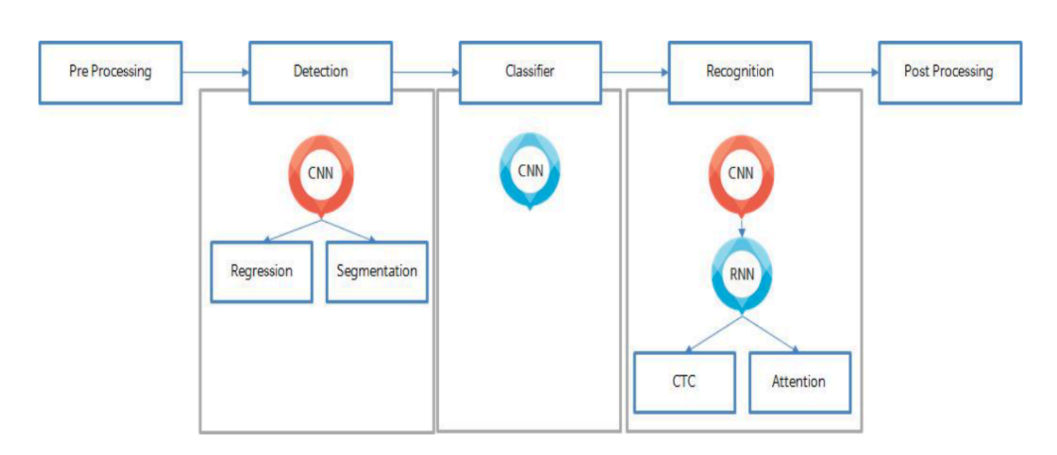